In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from matplotlib import gridspec
from IPython.display import Image
import theano.tensor as tt

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [64]:
df = pd.read_csv('data/HtWtData300.csv')
#df = pd.read_csv('data/HtWtData30.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    300 non-null    int64  
 1   height  300 non-null    float64
 2   weight  300 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.2 KB


In [65]:
# Standardize the data
zheight = ( (df['height']-df['height'].mean()) / df['height'].std() ).to_numpy()
zweight = ( (df['weight']-df['weight'].mean()) / df['weight'].std() ).to_numpy()

In [66]:
with pm.Model() as model:
    
    beta0 = pm.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pm.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight

    sigma = pm.Uniform('sigma', 10**-3, 10**3)
    nu = pm.Exponential('nu', 1/29.)
    
    likelihood = pm.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zweight)

In [67]:
with model:
    trace = pm.sample(3000, cores=2, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, beta1, beta0]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:08<00:00, 804.64draws/s] 


## Posterior Predictive Checks

In [68]:
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 6000/6000 [00:06<00:00, 930.76it/s]


In [69]:
ppc_trace['likelihood'].shape

(6000, 300)

(-3.0133562481781397, 6.622338999068915)

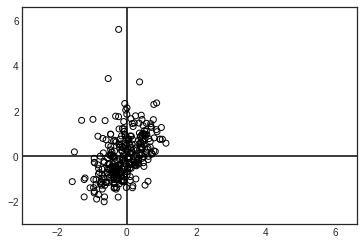

In [70]:
# plain vanilla PPC
# we'll plot the weights we observed for each individual
# against the mean "predicted" weight for those same individuals
plt.scatter(np.mean(ppc_trace['likelihood'], axis=0), zweight, facecolor='none', edgecolor='k')
mn = -1 + np.min([np.mean(ppc_trace['likelihood'], axis=0), zweight])
mx = 1 + np.max([np.mean(ppc_trace['likelihood'], axis=0), zweight])
#plt.plot([mn,mx],[mn,mx], c='k')
plt.plot([0,0],[mn,mx], c='k')
plt.plot([mn, mx],[0,0], c='k')
plt.xlim(mn,mx)
plt.ylim(mn,mx)

This looks ok.  The handful of weights are far greater than the predicted values.  These data points are likely to have been outliers in the original dataset itself.  For this reason, the discrepancy between the model and the predictions is not too overly concerning (although one would certainly want to follow this up to confirm the suspicion that these were empirical outliers).

Let's move on to composite variables generated using the set of predicted weights.  We can begin with inspecting some basic measures of central tendency.  Let's check to see whether our predictions about the mean weight are consistent with the mean of the weights observed in our sample.

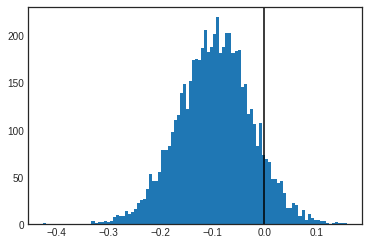

In [71]:
plt.hist([np.mean(weight) for weight in ppc_trace['likelihood']], bins=100);
plt.axvline(np.mean(zweight), c='k')

Hm.  That doesn't look quite right.  The observed mean is at 0.0, which makes sense because we are working with the standardized version of our weights.  But our predictions about the mean seem to be biased in the negative direction.  In other words, our posterior seems to suggest a smaller mean weight in our sample than we actually observed.

This seems like bad news, but it is important to remember that we modeled our data so as to be robust to outlying data points (outlying weights, specifically).  So perhaps we observed a few extremely large weights that are dragging the observed mean "upward".  If that explanation is correct, we would expect our posterior prediction about the _median_ weight to be more closely aligned with the observed median than the predicted _mean_ weight was.  Let's check.

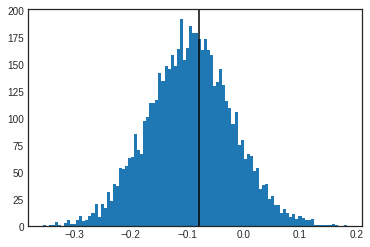

In [72]:
plt.hist([np.median(weight) for weight in ppc_trace['likelihood']], bins=100);
plt.axvline(np.median(zweight), c='k')

Great.  Our prediction about the median is pretty good.  We can do similar things for the standard deviation.

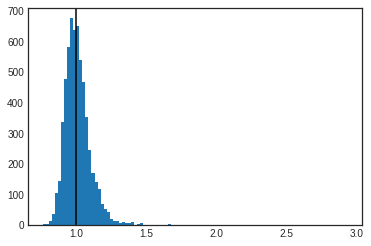

In [73]:
plt.hist([np.std(weight) for weight in ppc_trace['likelihood']], bins=100);
plt.axvline(np.std(zweight), c='k')

This also looks pretty good, although it is clear that we think the standard deviation could have credibly been substantialy larger than was actually observed.

# Extensions

Above, we have confined ourselves to posterior predictions about the weights our posterior "predicts" for each of the heights we observed in our sample.  However, there is no particular reason that we need to confine ourselves to the set of observed heights.  We can explore our predictions about a wide variety of heights.  We can also calculate a variety of composite variables that are based on the height and (predicted) weight variables.

Let's begin by visualizing credible regression lines.  We'll do so by sampling by going back to the trace generate during the sampling step we performed early inference (the sampling done for inference, not the set of posterior predictive samples).  We can use these credible parameter values, the intercept (`beta0`) and slope (`beta1`) in particular.  We can then take these credible intercept-slope pairs and generate a credible regression line for each one.

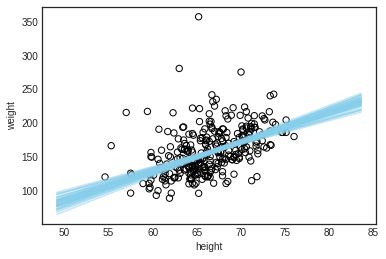

In [74]:
# create some synthetic heights
heights = np.linspace(df['height'].min()*.9, df['height'].max()*1.1, num=10)

sd_h = df['height'].std()
mean_h = df['height'].mean()
sd_w = df['weight'].std()
mean_w = df['weight'].mean()

# plot original data
plt.scatter(df['height'], df['weight'], s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=1)
plt.xlabel('height')
plt.ylabel('weight')

# sample 50 steps (sets of parameter values)
for i in range(50):
    step = np.random.choice(trace)
    # unstandardize the parameter values so we can plot in the native scale
    beta0 = (step['beta0']*sd_w)+ mean_w - (step['beta1']*mean_h*sd_w/sd_h)
    beta1 = step['beta1']*(sd_w/sd_h)
    weights = beta0 + (beta1 * heights)
    plt.plot(heights, weights, c='#87ceeb', alpha=.5, zorder=2)

If we squint, we can sort of make out a credible band of weights for each height.  This mimics an interval-valued function, in which each height is mapped to an interval of credible weights.  If we wish, we can simply calculate such intervals themselves.

In [75]:
# figure out the 95% credible interval
beta0 = (trace['beta0']*sd_w)+ mean_w - (trace['beta1']*mean_h*sd_w/sd_h)
beta1 = trace['beta1']*(sd_w/sd_h)

hpi_x = (50, 60,70,80)
hpi_y = np.zeros((len(hpi_x),2))


for i in range(len(hpi_x)):
    hpi_y[i,0] = np.percentile(beta0 + (beta1 * hpi_x[i]), 2.5)
    hpi_y[i,1] = np.percentile(beta0 + (beta1 * hpi_x[i]), 97.5)
    print(f'There is a 95% probabilty of someone of height {hpi_x[i]}'
          f' having a weight between {hpi_y[i,0]:.2f} and {hpi_y[i,1]:.2f}')

There is a 95% probabilty of someone of height 50 having a weight between 69.30 and 97.16
There is a 95% probabilty of someone of height 60 having a weight between 121.55 and 134.06
There is a 95% probabilty of someone of height 70 having a weight between 168.16 and 176.56
There is a 95% probabilty of someone of height 80 having a weight between 205.44 and 228.16


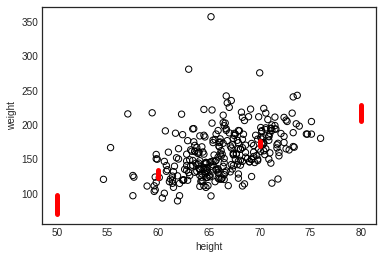

In [76]:
# plot original data
plt.scatter(df['height'], df['weight'], s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=1)
plt.xlabel('height')
plt.ylabel('weight')

# sample 50 steps (sets of parameter values)
for i in range(50):
    step = np.random.choice(trace)
    # unstandardize the parameter values so we can plot in the native scale
    beta0 = (step['beta0']*sd_w)+ mean_w - (step['beta1']*mean_h*sd_w/sd_h)
    beta1 = step['beta1']*(sd_w/sd_h)
    weights = beta0 + (beta1 * heights)
    #plt.plot(heights, weights, c='#87ceeb', alpha=.5, zorder=2)

for x,y in zip(hpi_x, hpi_y):
    plt.plot([x, x], y, lw=5, c='r', zorder=3);

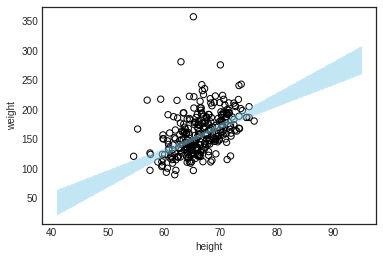

In [77]:
beta0 = (trace['beta0']*sd_w)+ mean_w - (trace['beta1']*mean_h*sd_w/sd_h)
beta1 = trace['beta1']*(sd_w/sd_h)

# plot original data
plt.scatter(df['height'], df['weight'], s=40, linewidths=1, facecolor='none', edgecolor='k', zorder=1)
plt.xlabel('height')
plt.ylabel('weight')

# create some new synthetic heights
heights = np.linspace(df['height'].min()*.75, df['height'].max()*1.25, num=305)

hpi_x = (heights)
hpi_y = np.zeros((len(hpi_x),2))

for i in range(len(hpi_x)):
    hpi_y[i,0] = np.percentile(beta0 + (beta1 * hpi_x[i]), 2.5)
    hpi_y[i,1] = np.percentile(beta0 + (beta1 * hpi_x[i]), 97.5)

for x,y in zip(hpi_x, hpi_y):
    plt.plot([x, x], y, lw=1, c='#87ceeb', alpha=.5, zorder=3)